# Optim


In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatib

In [12]:
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

# --- 1. Load DataFrames ---
df_orders = pd.read_csv('/content/orders_day9.csv')
df_distance = pd.read_csv('/content/distance_day9.csv', index_col=0)
df_time = pd.read_csv('/content/time_day9_optimistic.csv', index_col=0)

# --- PARAMETERS BASED ON MIP FORMULATION ---
# Alpha (α): Coefficient to penalize the number of vehicles. Must be large to prioritize
# vehicle count minimization over total travel time minimization.
ALPHA_VEHICLE_PENALTY = 200

# Physical Fleet Specifications (for sanity checks and fleet sizing)
PHYSICAL_FLEET_SPECS = {
    'weight': 2000,  # Max weight capacity of each truck
    'volume': 1000   # Max volume capacity of each truck
}

# Buffer time to ensure depot is open when vehicles return
BUFFER_RETURN_TIME = 200

# Extra vehicles to add beyond theoretical minimum
ROUTING_BUFFER = 5

# ----------------------------------------------------------------------
# --- 2. Data Structure Preparation for OR-Tools ---
# ----------------------------------------------------------------------

import math

def create_data_model_smart(orders_df, distance_df, time_df, physical_fleet_specs={}):
    """
    Initializes VRP data dynamically based on input statistics to ensure feasibility.

    physical_fleet_specs: dict containing 'weight_limit', 'volume_limit' of your REAL trucks.
    """
    data = {}

    # --- 1. Data Cleaning (Keep existing logic) ---
    distance_df.dropna(how='all', axis=0, inplace=True)
    distance_df.dropna(how='all', axis=1, inplace=True)
    time_df.dropna(how='all', axis=0, inplace=True)
    time_df.dropna(how='all', axis=1, inplace=True)

    data['distance_matrix'] = distance_df.values.astype(int).tolist()
    data['time_matrix'] = time_df.values.astype(int).tolist()

    # Determine the number of actual nodes from the distance matrix
    # Assuming node 0 is the depot and subsequent nodes are customers.
    num_problem_nodes = len(data['distance_matrix'])
    num_customers_from_matrices = num_problem_nodes - 1

    # Slice orders_df to match the number of customers implied by the matrices.
    # If df_orders has more customers than the distance matrix can support, it's truncated.
    # If df_orders has fewer customers, this will still work correctly.
    actual_orders_df = orders_df.head(num_customers_from_matrices)

    # --- 2. Smart Time Window Parsing ---
    parsed_windows = []
    max_deadline_in_data = 0

    # Depot is always (0,0) or (0, Open_Duration)
    # Let's assume Depot is open as long as the latest customer needs.
    parsed_windows.append((0, 0)) # Initial window for the depot (node 0)

    for tw_str in actual_orders_df['TIME_WINDOW']:
        # Parse the string "(900, 1200)" -> 900, 1200
        clean_str = tw_str.strip('()')
        if ',' in clean_str:
            parts = clean_str.split(',')
            start = int(parts[0])
            end = int(parts[1])
            parsed_windows.append((start, end))
            # Track the latest time anyone needs service
            if end > max_deadline_in_data:
                max_deadline_in_data = end
        else:
            # Fallback for bad data
            parsed_windows.append((0, 10000)) # Default fallback

    # Update Depot's window to extend to the latest deadline (plus return trip buffer)
    # This prevents the "Depot closed before driver returns" error.
    # approx time to drive back to depot after last delivery
    horizon = max_deadline_in_data + BUFFER_RETURN_TIME
    parsed_windows[0] = (0, horizon)

    data['time_windows'] = parsed_windows
    data['vehicle_max_travel_time'] = horizon # Set Horizon dynamically

    # --- 3. Demand & Capacity Sanity Check ---
    # Ensure weights are aligned with actual_orders_df
    data['weights'] = [0] + actual_orders_df['WEIGHT'].round().astype(int).tolist()

    # Notice: Multiplier is consistent (was 100 in your snippet, 1000 in previous. Check your data!)
    # Ensure volumes are aligned with actual_orders_df
    data['volumes'] = [0] + (actual_orders_df['VOLUME'] * 100).round().astype(int).tolist()

    # CONSTANTS (Physical limits of your trucks)
    TRUCK_W_CAP = physical_fleet_specs.get('weight', 2000)
    TRUCK_V_CAP = physical_fleet_specs.get('volume', 1000)

    # Sanity Check: Does the biggest order fit in a truck? (from actual_orders_df)
    if len(data['weights']) > 1: # Check only if there are customers
        max_order_w = max(data['weights'][1:]) # Exclude depot's 0 weight
        if max_order_w > TRUCK_W_CAP:
            raise ValueError(f"CRITICAL ERROR: Order exists with weight {max_order_w}, but truck limit is {TRUCK_W_CAP}.")

    # --- 4. Smart Fleet Sizing (The Lower Bound Calculation) ---
    total_weight = sum(data['weights'])
    total_volume = sum(data['volumes'])

    # Minimum trucks needed purely for capacity (Bin Packing Lower Bound)
    min_trucks_weight = math.ceil(total_weight / TRUCK_W_CAP)
    min_trucks_volume = math.ceil(total_volume / TRUCK_V_CAP)

    theoretical_min_vehicles = max(min_trucks_weight, min_trucks_volume)

    # Add a "Routing Buffer" (e.g., 20% or +2 trucks)
    # Vehicles can rarely be 100% full because they run out of Time or Distance first.
    recommended_fleet_size = int(theoretical_min_vehicles * 1.2) + ROUTING_BUFFER

    print(f"--- Initialization Report ---")
    print(f"Total Weight: {total_weight} | Max Truck W: {TRUCK_W_CAP} -> Min Trucks: {min_trucks_weight}")
    print(f"Total Volume: {total_volume} | Max Truck V: {TRUCK_V_CAP} -> Min Trucks: {min_trucks_volume}")
    print(f"Latest Deadline found: {max_deadline_in_data}")
    print(f"Number of nodes derived from distance matrix: {num_problem_nodes}")
    print(f"Number of customers used from orders_df: {len(actual_orders_df)}")
    print(f"Setting Fleet Size to: {recommended_fleet_size} (Theoretical Min: {theoretical_min_vehicles})")

    data['num_vehicles'] = recommended_fleet_size
    data['vehicle_capacities_weight'] = [TRUCK_W_CAP] * data['num_vehicles']
    data['vehicle_capacities_volume'] = [TRUCK_V_CAP] * data['num_vehicles']

    # --- 5. Other Data ---
    # Ensure service times are aligned with actual_orders_df
    data['service_times'] = [0] + actual_orders_df['SERVICE_TIME'].astype(int).tolist()
    data['depot'] = 0
    data['penalty'] = 100000 # Keep high

    return data

# ----------------------------------------------------------------------
# --- 3. Initialize Solver Model and Constraints ---
# ----------------------------------------------------------------------

def print_solution(data, manager, routing, solution):
   """Prints the solution found by the solver and returns structured route data."""
   total_distance = 0
   total_time_cost = 0 # Cost is now based on time, not distance
   total_time = 0
   time_dimension = routing.GetDimensionOrDie('Time')

   # --- Collect served nodes for later dropped node reporting ---
   served_nodes_set = set()
   all_routes_data = [] # List to store structured route data

   # Pre-calculate total travel time for objective reporting first
   # This loop only calculates total_time_cost and served_nodes_set
   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       route_path_nodes = []
       current_route_time_cost = 0
       current_route_distance = 0

       # Add depot as the start of the route
       route_path_nodes.append(manager.IndexToNode(index))

       while not routing.IsEnd(index):
           previous_index = index
           current_node_index = manager.IndexToNode(index)
           if current_node_index != data['depot']: # Don't add depot to served_nodes_set
               served_nodes_set.add(current_node_index)

           index = solution.Value(routing.NextVar(index))

           from_node = manager.IndexToNode(previous_index)
           to_node = manager.IndexToNode(index)
           current_route_time_cost += data['time_matrix'][from_node][to_node]
           current_route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)

           # Add node to current route path, except if it's the final depot return
           if not routing.IsEnd(index):
               route_path_nodes.append(to_node)
           else:
               route_path_nodes.append(data['depot']) # Add depot for end of route

       total_time_cost += current_route_time_cost
       total_distance += current_route_distance

   # Calculate objective based on MIP formulation: alpha * Yk + sum(tij * xijk)
   num_used_vehicles = len([v for v in range(data['num_vehicles']) if not routing.IsEnd(solution.Value(routing.NextVar(routing.Start(v))))])
   vehicle_penalty_component = num_used_vehicles * ALPHA_VEHICLE_PENALTY

   mip_objective = vehicle_penalty_component + total_time_cost

   print(f'OR-Tools Objective (Time Cost + Penalties): {solution.ObjectiveValue()}')
   print(f'MIP Objective (Alpha*Vehicles + Total Time): {mip_objective} ({num_used_vehicles} vehicles * {ALPHA_VEHICLE_PENALTY} + {total_time_cost})')

   # Print routes and collect data
   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       plan_output = f'Route for vehicle {vehicle_id} (Depot: 0):'
       route_distance = 0
       route_nodes_for_plot = []

       node_index_at_start = manager.IndexToNode(routing.Start(vehicle_id))
       route_nodes_for_plot.append(node_index_at_start)
       plan_output += f' {node_index_at_start} -> Time({solution.Min(time_dimension.CumulVar(index))})'

       while not routing.IsEnd(index):
           previous_index = index
           index = solution.Value(routing.NextVar(index))

           route_distance += routing.GetArcCostForVehicle(
               previous_index, index, vehicle_id
           )
           node_index = manager.IndexToNode(index)
           route_nodes_for_plot.append(node_index)
           time_var = time_dimension.CumulVar(index)
           plan_output += (
               f' {node_index} -> Time({solution.Min(time_var)})'
           )

       route_end_time = solution.Min(time_dimension.CumulVar(index))
       plan_output += f'\n  Route Distance: {route_distance}'
       plan_output += f'\n  Route End Time: {route_end_time}'

       print(plan_output)
       total_time = max(total_time, route_end_time)

       all_routes_data.append({
           'vehicle_id': vehicle_id,
           'route_nodes': route_nodes_for_plot,
           'route_distance': route_distance,
           'route_end_time': route_end_time
       })

   print(f'\nTotal distance of all used routes: {total_distance}')
   print(f'Max route end time: {total_time}')
   print(f'Total travel time cost: {total_time_cost} (The minimized sum component)')

   # --- Report Dropped Nodes (new approach) ---
   # All nodes from 1 to num_problem_nodes-1 are customer nodes
   all_customer_nodes = set(range(1, manager.GetNumberOfNodes()))
   dropped_nodes = list(all_customer_nodes - served_nodes_set)
   dropped_nodes.sort() # For consistent output

   if dropped_nodes:
       print(f'\n!!! WARNING: {len(dropped_nodes)} Nodes Were DROPPED (Unserved) !!!')
       print(f'Dropped Nodes (NODE_ID): {dropped_nodes}')
   else:
       print('\nSUCCESS: All nodes were served.')

   return all_routes_data, data


def solve_vrp():
   """Entry point for the VRP solver with MIP objective."""
   data = create_data_model_smart(df_orders, df_distance, df_time)

   manager = pywrapcp.RoutingIndexManager(
       len(data['distance_matrix']), data['num_vehicles'], data['depot']
   )

   routing = pywrapcp.RoutingModel(manager)

   # --- A. Define Cost (Time - as per MIP Objective) ---
   def time_cost_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       # The cost minimized is the travel time (t_ij)
       return data['time_matrix'][from_node][to_node]

   transit_callback_index = routing.RegisterTransitCallback(time_cost_callback)
   routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

   # A.1. Set Objective to Minimize Time Cost (t_ij) AND Penalize Vehicles (alpha * y_k)

   # Fixed cost (alpha * y_k): Apply a large penalty for using each vehicle
   for vehicle_id in range(data['num_vehicles']):
       routing.SetFixedCostOfVehicle(ALPHA_VEHICLE_PENALTY, vehicle_id)

   # A.2. Add Dropped Node Penalty
   # Iterate over customer nodes, not including the depot (node 0).
   # The range should be from 1 to num_problem_nodes - 1 (inclusive of the last customer).
   for node in range(1, len(data['distance_matrix'])):
       routing.AddDisjunction([manager.NodeToIndex(node)], data['penalty'])

   # --- B. Add Capacity Constraints (Weight and Volume) ---

   def add_capacity_dimension(capacity_name, capacities, demands):
       def demand_callback(index):
           node = manager.IndexToNode(index)
           return demands[node]

       demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

       # Capacity bounds are imposed at every node [cite: 87]
       routing.AddDimensionWithVehicleCapacity(
           demand_callback_index,
           0, # Slack
           capacities,
           True, # This dimension is cumulative
           capacity_name
       )

   add_capacity_dimension('WeightCapacity', data['vehicle_capacities_weight'], data['weights'])
   add_capacity_dimension('VolumeCapacity', data['vehicle_capacities_volume'], data['volumes'])


   # --- C. Add Time Window Constraints ---

   def time_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       travel_time = data['time_matrix'][from_node][to_node]
       service_time = data['service_times'][from_node]
       # Time propagation: T_jk >= T_ik + s_i + t_ij [cite: 99]
       return travel_time + service_time

   time_callback_index = routing.RegisterTransitCallback(time_callback)

   # Time dimension: tracks T_ik (time vehicle k starts service at node i) [cite: 45]
   routing.AddDimension(
       time_callback_index,
       0,                             # slack_max (0 is fine here)
       data['vehicle_max_travel_time'], # Planning horizon H [cite: 28]
       False,
       'Time'
   )
   time_dimension = routing.GetDimensionOrDie('Time')

   # Apply Time Windows [cite: 94]
   # The loop should iterate over the actual number of nodes in the problem
   for node in range(len(data['distance_matrix'])):
       index = manager.NodeToIndex(node)
       start, end = data['time_windows'][node]
       time_dimension.CumulVar(index).SetRange(start, end)

   # Apply Route Duration Constraint (limited by H) [cite: 104]
   for i in range(data['num_vehicles']):
       time_dimension.SetSpanUpperBoundForVehicle(
           data['vehicle_max_travel_time'],
           i
       )

   # --- D. Set Search Parameters and Solve ---
   search_parameters = pywrapcp.DefaultRoutingSearchParameters()
   search_parameters.first_solution_strategy = (
       routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
   )
   search_parameters.local_search_metaheuristic = (
       routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
   )
   search_parameters.time_limit.seconds = 120

   # Solve the problem
   solution = routing.SolveWithParameters(search_parameters)

   # --- E. Print Solution ---
   if solution:
       return print_solution(data, manager, routing, solution)
   else:
       print('No solution found!')
       return [], data # Return empty list and data object in case of no solution


# ----------------------------------------------------------------------
# --- EXECUTION --- (Moved to the visualization cell)
# ----------------------------------------------------------------------

--- Initialization Report ---
Total Weight: 1303 | Max Truck W: 2000 -> Min Trucks: 1
Total Volume: 524 | Max Truck V: 1000 -> Min Trucks: 1
Latest Deadline found: 360
Number of nodes derived from distance matrix: 85
Number of customers used from orders_df: 84
Setting Fleet Size to: 6 (Theoretical Min: 1)
OR-Tools Objective (Time Cost + Penalties): 1321
MIP Objective (Alpha*Vehicles + Total Time): 1321 (4 vehicles * 200 + 521)
Route for vehicle 1 (Depot: 0): 0 -> Time(0) 45 -> Time(18) 22 -> Time(28) 65 -> Time(35) 21 -> Time(45) 23 -> Time(57) 18 -> Time(74) 7 -> Time(79) 8 -> Time(85) 9 -> Time(91) 11 -> Time(102) 13 -> Time(116) 16 -> Time(133) 17 -> Time(147) 15 -> Time(153) 14 -> Time(161) 12 -> Time(176) 10 -> Time(192) 3 -> Time(200) 82 -> Time(207) 19 -> Time(219) 20 -> Time(228) 4 -> Time(243) 2 -> Time(260) 44 -> Time(267) 1 -> Time(274) 36 -> Time(280) 6 -> Time(288) 5 -> Time(297) 77 -> Time(311) 78 -> Time(320) 79 -> Time(329) 81 -> Time(340) 80 -> Time(349) 0 -> Time(379)

/tmp/ipython-input-813097466.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_routes_data))


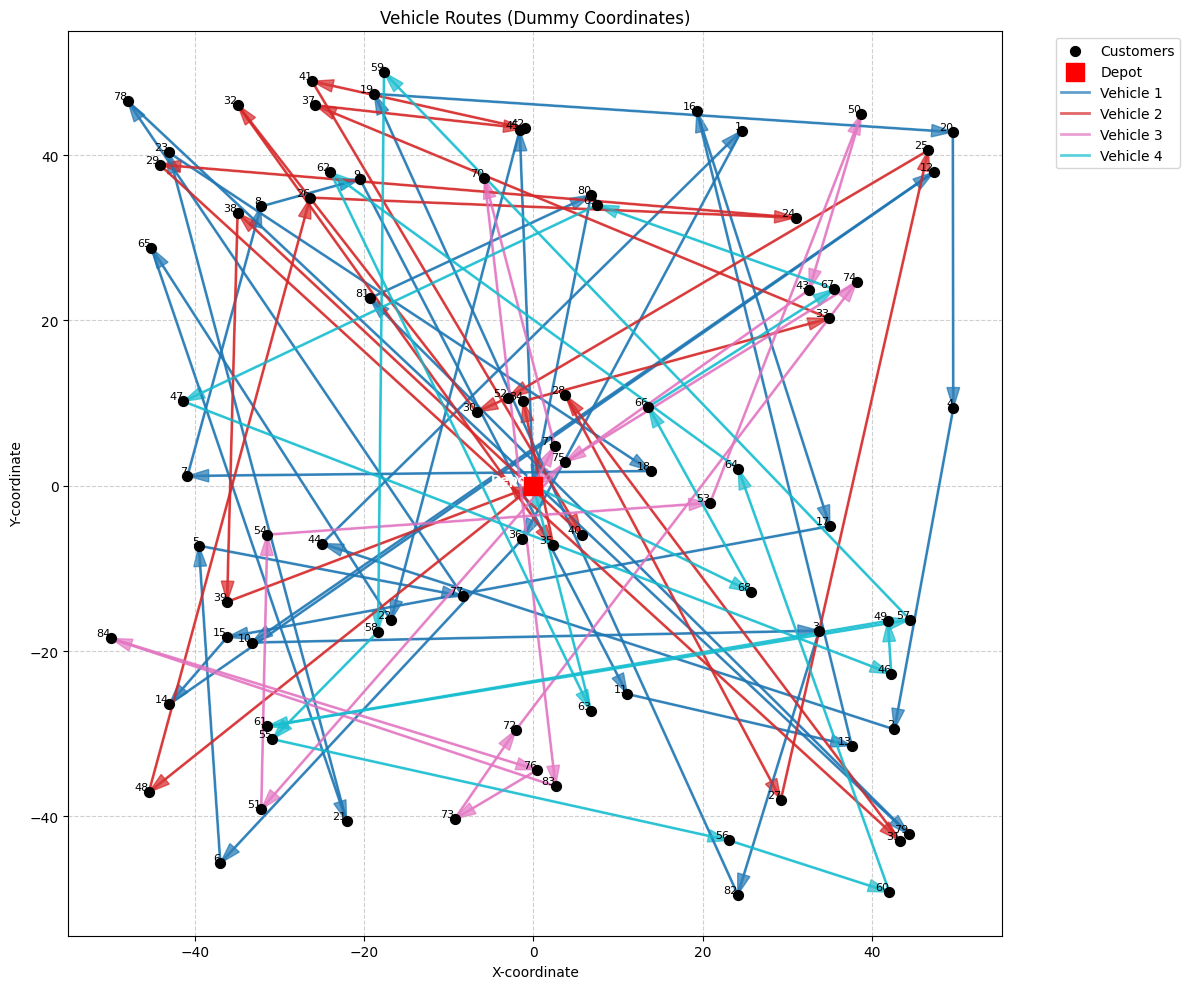

In [13]:
import matplotlib.pyplot as plt
import random

# Call the solver to get the routes and data model
all_routes_data, data = solve_vrp() # Changed to solve_vrp()
num_nodes = len(data['distance_matrix'])

# --- Generate Dummy Coordinates for Visualization ---
# For a better visualization, we'll create random coordinates for each node.
# Node 0 (depot) will be at the center (0,0).
# Other nodes will be randomly placed.

coordinates = [(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(num_nodes)]
coordinates[data['depot']] = (0, 0) # Set depot at origin

# --- Plotting the Routes ---
plt.figure(figsize=(12, 10))

# Plot all nodes first
node_x = [coord[0] for coord in coordinates]
node_y = [coord[1] for coord in coordinates]
plt.scatter(node_x, node_y, color='black', s=50, zorder=5, label='Customers')

# Highlight depot
depot_x, depot_y = coordinates[data['depot']]
plt.scatter(depot_x, depot_y, color='red', s=150, marker='s', zorder=6, label='Depot')
plt.text(depot_x, depot_y, 'Depot', fontsize=9, ha='right', va='bottom', color='white', weight='bold')

# Add node labels
for i, (x, y) in enumerate(coordinates):
    if i != data['depot']:
        plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

# Define a color palette for vehicles
colors = plt.cm.get_cmap('tab10', len(all_routes_data))

for idx, route_info in enumerate(all_routes_data):
    vehicle_id = route_info['vehicle_id']
    route_nodes = route_info['route_nodes']
    color = colors(idx)

    # Plot each segment of the route
    for i in range(len(route_nodes) - 1):
        start_node_idx = route_nodes[i]
        end_node_idx = route_nodes[i+1]

        start_x, start_y = coordinates[start_node_idx]
        end_x, end_y = coordinates[end_node_idx]

        plt.plot([start_x, end_x], [start_y, end_y], color=color, linewidth=2, alpha=0.7,
                 label=f'Vehicle {vehicle_id}' if i == 0 else "") # Label only once per vehicle
        plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
                  head_width=1.5, head_length=2.5, fc=color, ec=color, length_includes_head=True, alpha=0.7)

plt.title('Vehicle Routes (Dummy Coordinates)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Optimistic Solver (For Visualization - Original `solve_vrp` untouched)

In [ ]:
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

# --- 1. Load DataFrames ---
# Using the same dataframes as the optimistic scenario for this copy
df_orders_viz = pd.read_csv('/content/orders_day9.csv')
df_distance_viz = pd.read_csv('/content/distance_day9.csv', index_col=0)
df_time_viz = pd.read_csv('/content/time_day9_optimistic.csv', index_col=0)

# --- PARAMETERS BASED ON MIP FORMULATION ---
ALPHA_VEHICLE_PENALTY_VIZ = 200
PHYSICAL_FLEET_SPECS_VIZ = {
    'weight': 2000,
    'volume': 1000
}
BUFFER_RETURN_TIME_VIZ = 200
ROUTING_BUFFER_VIZ = 5

# Re-define create_data_model_smart to use the _viz dataframes
import math

def create_data_model_smart_viz(orders_df, distance_df, time_df, physical_fleet_specs={}):
    data = {}
    distance_df.dropna(how='all', axis=0, inplace=True)
    distance_df.dropna(how='all', axis=1, inplace=True)
    time_df.dropna(how='all', axis=0, inplace=True)
    time_df.dropna(how='all', axis=1, inplace=True)

    data['distance_matrix'] = distance_df.values.astype(int).tolist()
    data['time_matrix'] = time_df.values.astype(int).tolist()

    num_problem_nodes = len(data['distance_matrix'])
    num_customers_from_matrices = num_problem_nodes - 1
    actual_orders_df = orders_df.head(num_customers_from_matrices)

    parsed_windows = []
    max_deadline_in_data = 0
    parsed_windows.append((0, 0))

    for tw_str in actual_orders_df['TIME_WINDOW']:
        clean_str = tw_str.strip('()')
        if ',' in clean_str:
            parts = clean_str.split(',')
            start = int(parts[0])
            end = int(parts[1])
            parsed_windows.append((start, end))
            if end > max_deadline_in_data:
                max_deadline_in_data = end
        else:
            parsed_windows.append((0, 10000))

    horizon = max_deadline_in_data + BUFFER_RETURN_TIME_VIZ
    parsed_windows[0] = (0, horizon)

    data['time_windows'] = parsed_windows
    data['vehicle_max_travel_time'] = horizon

    data['weights'] = [0] + actual_orders_df['WEIGHT'].round().astype(int).tolist()
    data['volumes'] = [0] + (actual_orders_df['VOLUME'] * 100).round().astype(int).tolist()

    TRUCK_W_CAP = physical_fleet_specs.get('weight', 2000)
    TRUCK_V_CAP = physical_fleet_specs.get('volume', 1000)

    if len(data['weights']) > 1:
        max_order_w = max(data['weights'][1:])
        if max_order_w > TRUCK_W_CAP:
            raise ValueError(f"CRITICAL ERROR: Order exists with weight {max_order_w}, but truck limit is {TRUCK_W_CAP}.")

    total_weight = sum(data['weights'])
    total_volume = sum(data['volumes'])

    min_trucks_weight = math.ceil(total_weight / TRUCK_W_CAP)
    min_trucks_volume = math.ceil(total_volume / TRUCK_V_CAP)
    theoretical_min_vehicles = max(min_trucks_weight, min_trucks_volume)

    recommended_fleet_size = int(theoretical_min_vehicles * 1.2) + ROUTING_BUFFER_VIZ

    print(f"--- Initialization Report (for Visualization) ---")
    print(f"Total Weight: {total_weight} | Max Truck W: {TRUCK_W_CAP} -> Min Trucks: {min_trucks_weight}")
    print(f"Total Volume: {total_volume} | Max Truck V: {TRUCK_V_CAP} -> Min Trucks: {min_trucks_volume}")
    print(f"Latest Deadline found: {max_deadline_in_data}")
    print(f"Number of nodes derived from distance matrix: {num_problem_nodes}")
    print(f"Number of customers used from orders_df: {len(actual_orders_df)}")
    print(f"Setting Fleet Size to: {recommended_fleet_size} (Theoretical Min: {theoretical_min_vehicles})")

    data['num_vehicles'] = recommended_fleet_size
    data['vehicle_capacities_weight'] = [TRUCK_W_CAP] * data['num_vehicles']
    data['vehicle_capacities_volume'] = [TRUCK_V_CAP] * data['num_vehicles']

    data['service_times'] = [0] + actual_orders_df['SERVICE_TIME'].astype(int).tolist()
    data['depot'] = 0
    data['penalty'] = 100000

    return data

def print_solution_viz(data, manager, routing, solution):
   """Prints the solution found by the solver and returns structured route data."""
   total_distance = 0
   total_time_cost = 0
   total_time = 0
   time_dimension = routing.GetDimensionOrDie('Time')

   served_nodes_set = set()
   all_routes_data = []

   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       route_path_nodes = []
       current_route_time_cost = 0
       current_route_distance = 0

       route_path_nodes.append(manager.IndexToNode(index))

       while not routing.IsEnd(index):
           previous_index = index
           current_node_index = manager.IndexToNode(index)
           if current_node_index != data['depot']:
               served_nodes_set.add(current_node_index)

           index = solution.Value(routing.NextVar(index))

           from_node = manager.IndexToNode(previous_index)
           to_node = manager.IndexToNode(index)
           current_route_time_cost += data['time_matrix'][from_node][to_node]
           current_route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)

           if not routing.IsEnd(index):
               route_path_nodes.append(to_node)
           else:
               route_path_nodes.append(data['depot'])

       total_time_cost += current_route_time_cost
       total_distance += current_route_distance

   num_used_vehicles = len([v for v in range(data['num_vehicles']) if not routing.IsEnd(solution.Value(routing.NextVar(routing.Start(v))))])
   vehicle_penalty_component = num_used_vehicles * ALPHA_VEHICLE_PENALTY_VIZ

   mip_objective = vehicle_penalty_component + total_time_cost

   print(f'OR-Tools Objective (Time Cost + Penalties): {solution.ObjectiveValue()}')
   print(f'MIP Objective (Alpha*Vehicles + Total Time): {mip_objective} ({num_used_vehicles} vehicles * {ALPHA_VEHICLE_PENALTY_VIZ} + {total_time_cost})')

   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       plan_output = f'Route for vehicle {vehicle_id} (Depot: 0):'
       route_distance = 0
       route_nodes_for_plot = []

       node_index_at_start = manager.IndexToNode(routing.Start(vehicle_id))
       route_nodes_for_plot.append(node_index_at_start)
       plan_output += f' {node_index_at_start} -> Time({solution.Min(time_dimension.CumulVar(index))})'

       while not routing.IsEnd(index):
           previous_index = index
           index = solution.Value(routing.NextVar(index))

           route_distance += routing.GetArcCostForVehicle(
               previous_index, index, vehicle_id
           )
           node_index = manager.IndexToNode(index)
           route_nodes_for_plot.append(node_index)
           time_var = time_dimension.CumulVar(index)
           plan_output += (
               f' {node_index} -> Time({solution.Min(time_var)})'
           )

       route_end_time = solution.Min(time_dimension.CumulVar(index))
       plan_output += f'\n  Route Distance: {route_distance}'
       plan_output += f'\n  Route End Time: {route_end_time}'

       print(plan_output)
       total_time = max(total_time, route_end_time)

       all_routes_data.append({
           'vehicle_id': vehicle_id,
           'route_nodes': route_nodes_for_plot,
           'route_distance': route_distance,
           'route_end_time': route_end_time
       })

   print(f'\nTotal distance of all used routes: {total_distance}')
   print(f'Max route end time: {total_time}')
   print(f'Total travel time cost: {total_time_cost} (The minimized sum component)')

   all_customer_nodes = set(range(1, manager.GetNumberOfNodes()))
   dropped_nodes = list(all_customer_nodes - served_nodes_set)
   dropped_nodes.sort()

   if dropped_nodes:
       print(f'\n!!! WARNING: {len(dropped_nodes)} Nodes Were DROPPED (Unserved) !!!')
       print(f'Dropped Nodes (NODE_ID): {dropped_nodes}')
   else:
       print('\nSUCCESS: All nodes were served.')

   return all_routes_data, data

def solve_vrp_for_visualization():
   """Entry point for the VRP solver with MIP objective, returning data for visualization."""
   data = create_data_model_smart_viz(df_orders_viz, df_distance_viz, df_time_viz, PHYSICAL_FLEET_SPECS_VIZ)

   manager = pywrapcp.RoutingIndexManager(
       len(data['distance_matrix']), data['num_vehicles'], data['depot']
   )

   routing = pywrapcp.RoutingModel(manager)

   def time_cost_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       return data['time_matrix'][from_node][to_node]

   transit_callback_index = routing.RegisterTransitCallback(time_cost_callback)
   routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

   for vehicle_id in range(data['num_vehicles']):
       routing.SetFixedCostOfVehicle(ALPHA_VEHICLE_PENALTY_VIZ, vehicle_id)

   for node in range(1, len(data['distance_matrix'])):
       routing.AddDisjunction([manager.NodeToIndex(node)], data['penalty'])

   def add_capacity_dimension(capacity_name, capacities, demands):
       def demand_callback(index):
           node = manager.IndexToNode(index)
           return demands[node]

       demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

       routing.AddDimensionWithVehicleCapacity(
           demand_callback_index,
           0,
           capacities,
           True,
           capacity_name
       )

   add_capacity_dimension('WeightCapacity', data['vehicle_capacities_weight'], data['weights'])
   add_capacity_dimension('VolumeCapacity', data['vehicle_capacities_volume'], data['volumes'])

   def time_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       travel_time = data['time_matrix'][from_node][to_node]
       service_time = data['service_times'][from_node]
       return travel_time + service_time

   time_callback_index = routing.RegisterTransitCallback(time_callback)

   routing.AddDimension(
       time_callback_index,
       0,
       data['vehicle_max_travel_time'],
       False,
       'Time'
   )
   time_dimension = routing.GetDimensionOrDie('Time')

   for node in range(len(data['distance_matrix'])):
       index = manager.NodeToIndex(node)
       start, end = data['time_windows'][node]
       time_dimension.CumulVar(index).SetRange(start, end)

   for i in range(data['num_vehicles']):
       time_dimension.SetSpanUpperBoundForVehicle(
           data['vehicle_max_travel_time'],
           i
       )

   search_parameters = pywrapcp.DefaultRoutingSearchParameters()
   search_parameters.first_solution_strategy = (
       routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
   )
   search_parameters.local_search_metaheuristic = (
       routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
   )
   search_parameters.time_limit.seconds = 120

   solution = routing.SolveWithParameters(search_parameters)

   if solution:
       return print_solution_viz(data, manager, routing, solution)
   else:
       print('No solution found!')
       return [], data


#### Visualization of Optimistic Scenario Routes

--- Initialization Report (for Visualization) ---
Total Weight: 1155 | Max Truck W: 2000 -> Min Trucks: 1
Total Volume: 446 | Max Truck V: 1000 -> Min Trucks: 1
Latest Deadline found: 360
Number of nodes derived from distance matrix: 79
Number of customers used from orders_df: 78
Setting Fleet Size to: 6 (Theoretical Min: 1)
OR-Tools Objective (Time Cost + Penalties): 1250
MIP Objective (Alpha*Vehicles + Total Time): 1250 (4 vehicles * 200 + 450)
Route for vehicle 1 (Depot: 0): 0 -> Time(0) 44 -> Time(26) 45 -> Time(34) 48 -> Time(42) 47 -> Time(47) 50 -> Time(63) 22 -> Time(77) 53 -> Time(85) 52 -> Time(99) 23 -> Time(112) 19 -> Time(127) 55 -> Time(134) 54 -> Time(155) 58 -> Time(173) 57 -> Time(179) 59 -> Time(194) 15 -> Time(201) 0 -> Time(223)
  Route Distance: 295
  Route End Time: 223
Route for vehicle 2 (Depot: 0): 0 -> Time(0) 16 -> Time(18) 11 -> Time(32) 56 -> Time(52) 5 -> Time(68) 18 -> Time(88) 12 -> Time(102) 17 -> Time(116) 14 -> Time(128) 7 -> Time(156) 0 -> Time(180)


/tmp/ipython-input-1627322346.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_routes_data_optimistic))


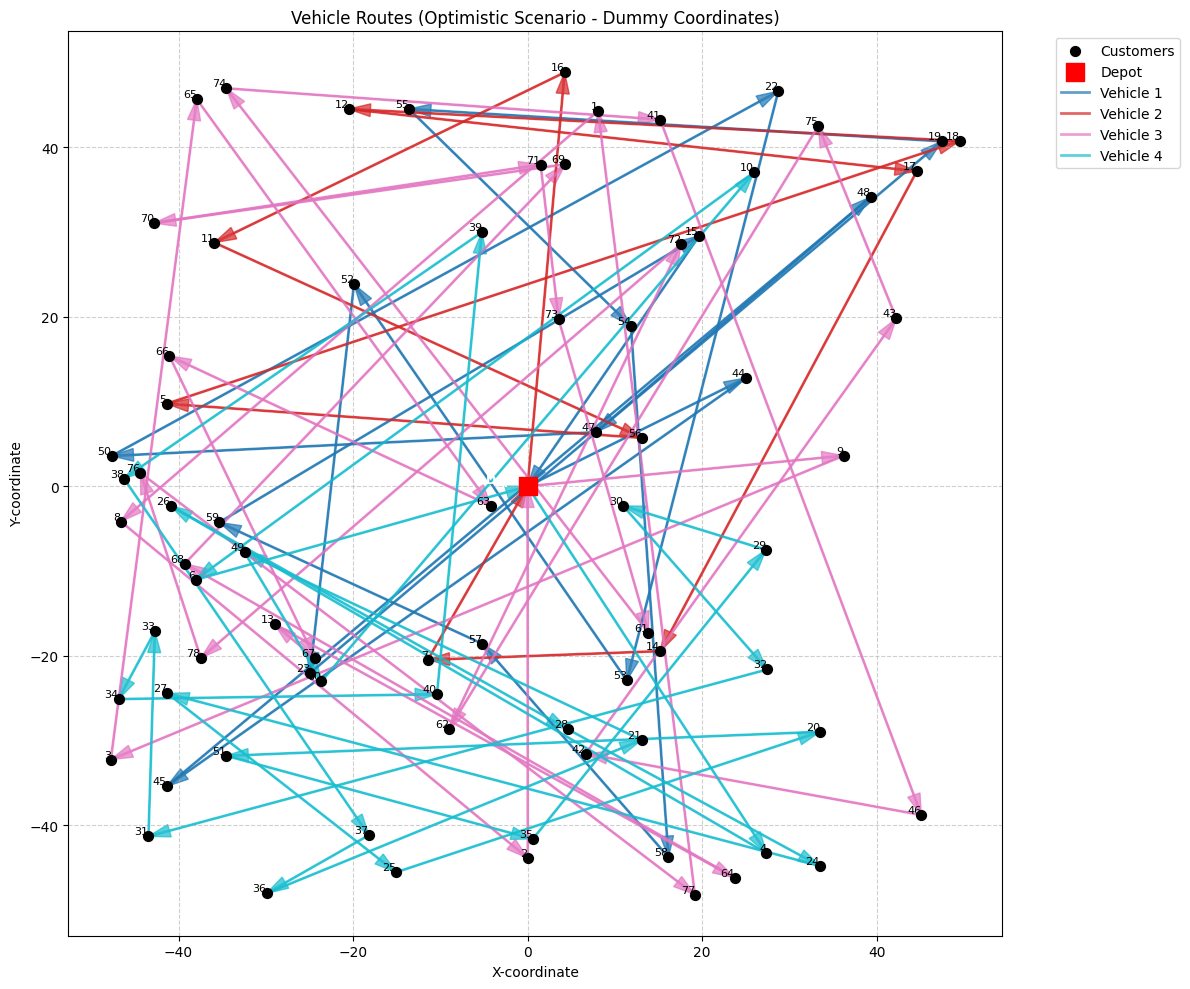

In [ ]:
import matplotlib.pyplot as plt
import random

# Call the new solver function to get the routes and data model for visualization
all_routes_data_optimistic, data_optimistic = solve_vrp_for_visualization()
num_nodes_optimistic = len(data_optimistic['distance_matrix'])

# --- Generate Dummy Coordinates for Visualization ---
coordinates_optimistic = [(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(num_nodes_optimistic)]
coordinates_optimistic[data_optimistic['depot']] = (0, 0) # Set depot at origin

# --- Plotting the Routes ---
plt.figure(figsize=(12, 10))

# Plot all nodes first
node_x_optimistic = [coord[0] for coord in coordinates_optimistic]
node_y_optimistic = [coord[1] for coord in coordinates_optimistic]
plt.scatter(node_x_optimistic, node_y_optimistic, color='black', s=50, zorder=5, label='Customers')

# Highlight depot
depot_x_optimistic, depot_y_optimistic = coordinates_optimistic[data_optimistic['depot']]
plt.scatter(depot_x_optimistic, depot_y_optimistic, color='red', s=150, marker='s', zorder=6, label='Depot')
plt.text(depot_x_optimistic, depot_y_optimistic, 'Depot', fontsize=9, ha='right', va='bottom', color='white', weight='bold')

# Add node labels
for i, (x, y) in enumerate(coordinates_optimistic):
    if i != data_optimistic['depot']:
        plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

# Define a color palette for vehicles
colors = plt.cm.get_cmap('tab10', len(all_routes_data_optimistic))

for idx, route_info in enumerate(all_routes_data_optimistic):
    vehicle_id = route_info['vehicle_id']
    route_nodes = route_info['route_nodes']
    color = colors(idx)

    # Plot each segment of the route
    for i in range(len(route_nodes) - 1):
        start_node_idx = route_nodes[i]
        end_node_idx = route_nodes[i+1]

        start_x, start_y = coordinates_optimistic[start_node_idx]
        end_x, end_y = coordinates_optimistic[end_node_idx]

        plt.plot([start_x, end_x], [start_y, end_y], color=color, linewidth=2, alpha=0.7,
                 label=f'Vehicle {vehicle_id}' if i == 0 else "") # Label only once per vehicle
        plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
                  head_width=1.5, head_length=2.5, fc=color, ec=color, length_includes_head=True, alpha=0.7)

plt.title('Vehicle Routes (Optimistic Scenario - Dummy Coordinates)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Visualization of MPSolver (MIP) Scenario Routes

# Pessim

In [ ]:
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

# --- 1. Load DataFrames ---
df_orders = pd.read_csv('/content/orders_day9.csv')
df_distance = pd.read_csv('/content/distance_day9.csv', index_col=0)
df_time = pd.read_csv('/content/time_day9_pessimistic.csv', index_col=0)

# --- PARAMETERS BASED ON MIP FORMULATION ---
# Alpha (α): Coefficient to penalize the number of vehicles. Must be large to prioritize
# vehicle count minimization over total travel time minimization.
ALPHA_VEHICLE_PENALTY = 200

# Physical Fleet Specifications (for sanity checks and fleet sizing)
PHYSICAL_FLEET_SPECS = {
    'weight': 2000,  # Max weight capacity of each truck
    'volume': 1000   # Max volume capacity of each truck
}

# Buffer time to ensure depot is open when vehicles return
BUFFER_RETURN_TIME = 200

# Extra vehicles to add beyond theoretical minimum
ROUTING_BUFFER = 5

# ----------------------------------------------------------------------
# --- 2. Data Structure Preparation for OR-Tools ---
# ----------------------------------------------------------------------

import math

def create_data_model_smart(orders_df, distance_df, time_df, physical_fleet_specs={}):
    """
    Initializes VRP data dynamically based on input statistics to ensure feasibility.

    physical_fleet_specs: dict containing 'weight_limit', 'volume_limit' of your REAL trucks.
    """
    data = {}

    # --- 1. Data Cleaning (Keep existing logic) ---
    distance_df.dropna(how='all', axis=0, inplace=True)
    distance_df.dropna(how='all', axis=1, inplace=True)
    time_df.dropna(how='all', axis=0, inplace=True)
    time_df.dropna(how='all', axis=1, inplace=True)

    data['distance_matrix'] = distance_df.values.astype(int).tolist()
    data['time_matrix'] = time_df.values.astype(int).tolist()

    # Determine the number of actual nodes from the distance matrix
    # Assuming node 0 is the depot and subsequent nodes are customers.
    num_problem_nodes = len(data['distance_matrix'])
    num_customers_from_matrices = num_problem_nodes - 1

    # Slice orders_df to match the number of customers implied by the matrices.
    # If df_orders has more customers than the distance matrix can support, it's truncated.
    # If df_orders has fewer customers, this will still work correctly.
    actual_orders_df = orders_df.head(num_customers_from_matrices)

    # --- 2. Smart Time Window Parsing ---
    parsed_windows = []
    max_deadline_in_data = 0

    # Depot is always (0,0) or (0, Open_Duration)
    # Let's assume Depot is open as long as the latest customer needs.
    parsed_windows.append((0, 0)) # Initial window for the depot (node 0)

    for tw_str in actual_orders_df['TIME_WINDOW']:
        # Parse the string "(900, 1200)" -> 900, 1200
        clean_str = tw_str.strip('()')
        if ',' in clean_str:
            parts = clean_str.split(',')
            start = int(parts[0])
            end = int(parts[1])
            parsed_windows.append((start, end))
            # Track the latest time anyone needs service
            if end > max_deadline_in_data:
                max_deadline_in_data = end
        else:
            # Fallback for bad data
            parsed_windows.append((0, 10000)) # Default fallback

    # Update Depot's window to extend to the latest deadline (plus return trip buffer)
    # This prevents the "Depot closed before driver returns" error.
    # approx time to drive back to depot after last delivery
    horizon = max_deadline_in_data + BUFFER_RETURN_TIME
    parsed_windows[0] = (0, horizon)

    data['time_windows'] = parsed_windows
    data['vehicle_max_travel_time'] = horizon # Set Horizon dynamically

    # --- 3. Demand & Capacity Sanity Check ---
    # Ensure weights are aligned with actual_orders_df
    data['weights'] = [0] + actual_orders_df['WEIGHT'].round().astype(int).tolist()

    # Notice: Multiplier is consistent (was 100 in your snippet, 1000 in previous. Check your data!)
    # Ensure volumes are aligned with actual_orders_df
    data['volumes'] = [0] + (actual_orders_df['VOLUME'] * 100).round().astype(int).tolist()

    # CONSTANTS (Physical limits of your trucks)
    TRUCK_W_CAP = physical_fleet_specs.get('weight', 2000)
    TRUCK_V_CAP = physical_fleet_specs.get('volume', 1000)

    # Sanity Check: Does the biggest order fit in a truck? (from actual_orders_df)
    if len(data['weights']) > 1: # Check only if there are customers
        max_order_w = max(data['weights'][1:]) # Exclude depot's 0 weight
        if max_order_w > TRUCK_W_CAP:
            raise ValueError(f"CRITICAL ERROR: Order exists with weight {max_order_w}, but truck limit is {TRUCK_W_CAP}.")

    # --- 4. Smart Fleet Sizing (The Lower Bound Calculation) ---
    total_weight = sum(data['weights'])
    total_volume = sum(data['volumes'])

    # Minimum trucks needed purely for capacity (Bin Packing Lower Bound)
    min_trucks_weight = math.ceil(total_weight / TRUCK_W_CAP)
    min_trucks_volume = math.ceil(total_volume / TRUCK_V_CAP)

    theoretical_min_vehicles = max(min_trucks_weight, min_trucks_volume)

    # Add a "Routing Buffer" (e.g., 20% or +2 trucks)
    # Vehicles can rarely be 100% full because they run out of Time or Distance first.
    recommended_fleet_size = int(theoretical_min_vehicles * 1.2) + ROUTING_BUFFER

    print(f"--- Initialization Report ---")
    print(f"Total Weight: {total_weight} | Max Truck W: {TRUCK_W_CAP} -> Min Trucks: {min_trucks_weight}")
    print(f"Total Volume: {total_volume} | Max Truck V: {TRUCK_V_CAP} -> Min Trucks: {min_trucks_volume}")
    print(f"Latest Deadline found: {max_deadline_in_data}")
    print(f"Number of nodes derived from distance matrix: {num_problem_nodes}")
    print(f"Number of customers used from orders_df: {len(actual_orders_df)}")
    print(f"Setting Fleet Size to: {recommended_fleet_size} (Theoretical Min: {theoretical_min_vehicles})")

    data['num_vehicles'] = recommended_fleet_size
    data['vehicle_capacities_weight'] = [TRUCK_W_CAP] * data['num_vehicles']
    data['vehicle_capacities_volume'] = [TRUCK_V_CAP] * data['num_vehicles']

    # --- 5. Other Data ---
    # Ensure service times are aligned with actual_orders_df
    data['service_times'] = [0] + actual_orders_df['SERVICE_TIME'].astype(int).tolist()
    data['depot'] = 0
    data['penalty'] = 100000 # Keep high

    return data

# ----------------------------------------------------------------------
# --- 3. Initialize Solver Model and Constraints ---
# ----------------------------------------------------------------------

def print_solution(data, manager, routing, solution):
   """Prints the solution found by the solver."""
   total_distance = 0
   total_time_cost = 0 # Cost is now based on time, not distance
   total_time = 0
   time_dimension = routing.GetDimensionOrDie('Time')

   # --- Collect served nodes for later dropped node reporting ---
   served_nodes_set = set()

   # Calculate the total travel time for the objective reporting
   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       while not routing.IsEnd(index):
           previous_index = index
           current_node_index = manager.IndexToNode(index)
           if current_node_index != data['depot']: # Don't add depot to served_nodes_set
               served_nodes_set.add(current_node_index)

           index = solution.Value(routing.NextVar(index))

           # The actual total travel time component of the objective
           from_node = manager.IndexToNode(previous_index)
           to_node = manager.IndexToNode(index)
           # The cost minimized is the travel time (t_ij)
           total_time_cost += data['time_matrix'][from_node][to_node]

   # Calculate objective based on MIP formulation: alpha * Yk + sum(tij * xijk)
   num_used_vehicles = len([v for v in range(data['num_vehicles']) if not routing.IsEnd(solution.Value(routing.NextVar(routing.Start(v))))])
   vehicle_penalty_component = num_used_vehicles * ALPHA_VEHICLE_PENALTY

   # NOTE: The OR-Tools objective value here may include dropped node penalties,
   # but the custom calculation below reflects the MIP goal:
   mip_objective = vehicle_penalty_component + total_time_cost

   print(f'OR-Tools Objective (Time Cost + Penalties): {solution.ObjectiveValue()}')
   print(f'MIP Objective (Alpha*Vehicles + Total Time): {mip_objective} ({num_used_vehicles} vehicles * {ALPHA_VEHICLE_PENALTY} + {total_time_cost})')

   # Print routes (unchanged)
   for vehicle_id in range(data['num_vehicles']):
       index = routing.Start(vehicle_id)
       if routing.IsEnd(solution.Value(routing.NextVar(index))):
           continue

       plan_output = f'Route for vehicle {vehicle_id} (Depot: 0):'
       route_distance = 0

       while not routing.IsEnd(index):
           time_var = time_dimension.CumulVar(index)
           node_index = manager.IndexToNode(index)

           previous_index = index
           index = solution.Value(routing.NextVar(index))

           route_distance += routing.GetArcCostForVehicle(
               previous_index, index, vehicle_id
           )

           plan_output += (
               f' {node_index} -> Time({solution.Min(time_var)})'
           )

       time_var = time_dimension.CumulVar(index)
       plan_output += (
           f' {manager.IndexToNode(index)} -> Time({solution.Min(time_var)})'
       )
       plan_output += f'\n  Route Distance: {route_distance}'
       plan_output += f'\n  Route End Time: {solution.Min(time_var)}'

       print(plan_output)
       total_distance += route_distance
       total_time = max(total_time, solution.Min(time_var))

   print(f'\nTotal distance of all used routes: {total_distance}')
   print(f'Max route end time: {total_time}')
   print(f'Total travel time cost: {total_time_cost} (The minimized sum component)')

   # --- Report Dropped Nodes (new approach) ---
   # All nodes from 1 to num_problem_nodes-1 are customer nodes
   all_customer_nodes = set(range(1, manager.GetNumberOfNodes()))
   dropped_nodes = list(all_customer_nodes - served_nodes_set)
   dropped_nodes.sort() # For consistent output

   if dropped_nodes:
       print(f'\n!!! WARNING: {len(dropped_nodes)} Nodes Were DROPPED (Unserved) !!!')
       print(f'Dropped Nodes (NODE_ID): {dropped_nodes}')
   else:
       print('\nSUCCESS: All nodes were served.')


def solve_vrp():
   """Entry point for the VRP solver with MIP objective."""
   data = create_data_model_smart(df_orders, df_distance, df_time)

   manager = pywrapcp.RoutingIndexManager(
       len(data['distance_matrix']), data['num_vehicles'], data['depot']
   )

   routing = pywrapcp.RoutingModel(manager)

   # --- A. Define Cost (Time - as per MIP Objective) ---
   def time_cost_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       # The cost minimized is the travel time (t_ij)
       return data['time_matrix'][from_node][to_node]

   transit_callback_index = routing.RegisterTransitCallback(time_cost_callback)
   routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

   # A.1. Set Objective to Minimize Time Cost (t_ij) AND Penalize Vehicles (alpha * y_k)

   # Fixed cost (alpha * y_k): Apply a large penalty for using each vehicle
   for vehicle_id in range(data['num_vehicles']):
       routing.SetFixedCostOfVehicle(ALPHA_VEHICLE_PENALTY, vehicle_id)

   # A.2. Add Dropped Node Penalty
   # Iterate over customer nodes, not including the depot (node 0).
   # The range should be from 1 to num_problem_nodes - 1 (inclusive of the last customer).
   for node in range(1, len(data['distance_matrix'])):
       routing.AddDisjunction([manager.NodeToIndex(node)], data['penalty'])

   # --- B. Add Capacity Constraints (Weight and Volume) ---

   def add_capacity_dimension(capacity_name, capacities, demands):
       def demand_callback(index):
           node = manager.IndexToNode(index)
           return demands[node]

       demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

       # Capacity bounds are imposed at every node [cite: 87]
       routing.AddDimensionWithVehicleCapacity(
           demand_callback_index,
           0, # Slack
           capacities,
           True, # This dimension is cumulative
           capacity_name
       )

   add_capacity_dimension('WeightCapacity', data['vehicle_capacities_weight'], data['weights'])
   add_capacity_dimension('VolumeCapacity', data['vehicle_capacities_volume'], data['volumes'])


   # --- C. Add Time Window Constraints ---

   def time_callback(from_index, to_index):
       from_node = manager.IndexToNode(from_index)
       to_node = manager.IndexToNode(to_index)
       travel_time = data['time_matrix'][from_node][to_node]
       service_time = data['service_times'][from_node]
       # Time propagation: T_jk >= T_ik + s_i + t_ij [cite: 99]
       return travel_time + service_time

   time_callback_index = routing.RegisterTransitCallback(time_callback)

   # Time dimension: tracks T_ik (time vehicle k starts service at node i) [cite: 45]
   routing.AddDimension(
       time_callback_index,
       0,                             # slack_max (0 is fine here)
       data['vehicle_max_travel_time'], # Planning horizon H [cite: 28]
       False,
       'Time'
   )
   time_dimension = routing.GetDimensionOrDie('Time')

   # Apply Time Windows [cite: 94]
   # The loop should iterate over the actual number of nodes in the problem
   for node in range(len(data['distance_matrix'])):
       index = manager.NodeToIndex(node)
       start, end = data['time_windows'][node]
       time_dimension.CumulVar(index).SetRange(start, end)

   # Apply Route Duration Constraint (limited by H) [cite: 104]
   for i in range(data['num_vehicles']):
       time_dimension.SetSpanUpperBoundForVehicle(
           data['vehicle_max_travel_time'],
           i
       )

   # --- D. Set Search Parameters and Solve ---
   search_parameters = pywrapcp.DefaultRoutingSearchParameters()
   search_parameters.first_solution_strategy = (
       routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
   )
   search_parameters.local_search_metaheuristic = (
       routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
   )
   search_parameters.time_limit.seconds = 120

   # Solve the problem
   solution = routing.SolveWithParameters(search_parameters)

   # --- E. Print Solution ---
   if solution:
       print_solution(data, manager, routing, solution)
   else:
       print('No solution found!')


# ----------------------------------------------------------------------
# --- EXECUTION ---
# ----------------------------------------------------------------------

print("Running Vehicle Routing Problem Solver (MIP Objective: Minimize Vehicles, then Time)...")
solve_vrp()

Running Vehicle Routing Problem Solver (MIP Objective: Minimize Vehicles, then Time)...
--- Initialization Report ---
Total Weight: 1303 | Max Truck W: 2000 -> Min Trucks: 1
Total Volume: 524 | Max Truck V: 1000 -> Min Trucks: 1
Latest Deadline found: 360
Number of nodes derived from distance matrix: 85
Number of customers used from orders_df: 84
Setting Fleet Size to: 6 (Theoretical Min: 1)
OR-Tools Objective (Time Cost + Penalties): 1882
MIP Objective (Alpha*Vehicles + Total Time): 1882 (5 vehicles * 200 + 882)
Route for vehicle 0 (Depot: 0): 0 -> Time(0) 51 -> Time(31) 52 -> Time(69) 30 -> Time(86) 31 -> Time(99) 28 -> Time(115) 27 -> Time(128) 29 -> Time(137) 25 -> Time(154) 26 -> Time(175) 24 -> Time(190) 21 -> Time(202) 65 -> Time(213) 22 -> Time(222) 45 -> Time(237) 84 -> Time(244) 0 -> Time(275)
  Route Distance: 351
  Route End Time: 275
Route for vehicle 1 (Depot: 0): 0 -> Time(0) 70 -> Time(22) 71 -> Time(34) 83 -> Time(60) 23 -> Time(94) 18 -> Time(118) 7 -> Time(125) 8 -> 

# Task
Implement the Vehicle Routing Problem (VRP) solver using OR-Tools' MPSolver (`pywraplp`) by defining variables, the objective function to minimize vehicles and total travel time, and core constraints for time windows and capacities, replacing the existing CP-based solver logic.(using branch and bound instead)

In [ ]:
from ortools.linear_solver import pywraplp
df_orders = pd.read_csv('/content/sample_data/orders_day9.csv')
df_distance = pd.read_csv('/content/distance_day9.csv', index_col=0)
df_time = pd.read_csv('/content/sample_data/time_day9_optimistic.csv', index_col=0)
def solve_vrp_with_mpsolver():
    """Entry point for the VRP solver using MPSolver."""
    data = create_data_model_smart(df_orders, df_distance, df_time)

    # Create the MPSolver.
    # Try 'CBC' or 'SCIP' for the solver backend.
    # SCIP is generally more powerful but CBC is often sufficient for VRPs.
    # Correct way to instantiate Solver:
    solver = pywraplp.Solver('VRP_MPSolver', pywraplp.Solver.SCIP_MIXED_INTEGER_PROGRAMMING)

    if not solver:
        print('Could not create solver SCIP. Falling back to CBC.')
        solver = pywraplp.Solver('VRP_MPSolver', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        if not solver:
            raise ValueError('Could not create any solver.')

    print(f'Using solver: {solver.SolverVersion()}')

    num_nodes = len(data['distance_matrix'])
    num_vehicles = data['num_vehicles']
    max_travel_time = data['vehicle_max_travel_time']
    max_weight_capacity = data['vehicle_capacities_weight'][0] # Assuming all vehicles have same capacity
    max_volume_capacity = data['vehicle_capacities_volume'][0] # Assuming all vehicles have same capacity

    # 1. Decision variable x_ijk: 1 if vehicle k travels from node i to node j
    x = {}
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j: # Exclude self-loops
                continue
            for k in range(num_vehicles):
                x[(i, j, k)] = solver.BoolVar(f'x_{i}_{j}_{k}')

    # 2. Decision variable y_k: 1 if vehicle k is used
    y = {}
    for k in range(num_vehicles):
        y[k] = solver.BoolVar(f'y_{k}')

    # 3. Continuous variable arrival_time[i][k]: arrival time of vehicle k at node i (T_ik)
    arrival_time = {}
    for i in range(num_nodes):
        for k in range(num_vehicles):
            # Lower bound 0, Upper bound vehicle_max_travel_time (H)
            arrival_time[(i, k)] = solver.NumVar(0, max_travel_time, f'T_{i}_{k}')

    # 4. Continuous variables load_w[i][k] and load_v[i][k]: load of vehicle k after visiting node i
    load_w = {}
    load_v = {}
    for i in range(num_nodes):
        for k in range(num_vehicles):
            # Lower bound 0, Upper bound max_weight_capacity
            load_w[(i, k)] = solver.NumVar(0, max_weight_capacity, f'LW_{i}_{k}')
            # Lower bound 0, Upper bound max_volume_capacity
            load_v[(i, k)] = solver.NumVar(0, max_volume_capacity, f'LV_{i}_{k}')

    # Define Objective Function
    objective = solver.Objective()

    # Minimize total number of vehicles used
    for k in range(num_vehicles):
        objective.SetCoefficient(y[k], ALPHA_VEHICLE_PENALTY)

    # Minimize total travel time
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            for k in range(num_vehicles):
                objective.SetCoefficient(x[(i, j, k)], data['time_matrix'][i][j])

    objective.SetMinimization()

    # --- Define Routing Constraints --- (from previous steps)

    # Constraint 1: Each customer node (1 to num_nodes-1) is visited exactly once.
    for j in range(1, num_nodes): # For each customer node
        solver.Add(solver.Sum(x[(i, j, k)] for i in range(num_nodes) if i != j for k in range(num_vehicles)) == 1)

    # Constraint 2: Each vehicle starts its route from the depot (node 0) at most once.
    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[(0, j, k)] for j in range(1, num_nodes)) <= y[k])

    # Constraint 3: Flow conservation (if a vehicle enters a node, it must leave that node).
    for i in range(1, num_nodes): # For each customer node
        for k in range(num_vehicles):
            solver.Add(solver.Sum(x[(j, i, k)] for j in range(num_nodes) if j != i) ==
                       solver.Sum(x[(i, j_prime, k)] for j_prime in range(num_nodes) if j_prime != i))

    # Constraint 4: Each vehicle returns to the depot (node 0).
    for k in range(num_vehicles):
        solver.Add(solver.Sum(x[(i, 0, k)] for i in range(1, num_nodes)) == y[k])

    # Constraint 5: Link x_ijk variables to y_k variables (if any vehicle k travels on any arc, then y_k must be 1).
    # If a vehicle starts from the depot, then it is used.
    for k in range(num_vehicles):
        for j in range(1, num_nodes):
            # If x_0jk is 1, then y_k must be 1.  This is equivalent to x_0jk <= y_k
            solver.Add(x[(0, j, k)] <= y[k])

    # --- Define Capacity Constraints (Weight and Volume) --- (from previous steps)

    M_w = max_weight_capacity # Big M for weight
    M_v = max_volume_capacity # Big M for volume

    # Constraint 1 & 2 (Implicit and Explicit): Ensure load at node i accounts for demand at i.
    # This is covered by the flow constraints and variable definition. No extra constraint needed here.

    # Constraint 3 & 4: Load update using Big-M formulation (for equality now)
    # If x[(i, j, k)] = 1, then load_w[(j, k)] = load_w[(i, k)] + data['weights'][j]
    for i in range(num_nodes):
        for j in range(1, num_nodes): # For each customer node j
            if i == j:
                continue
            for k in range(num_vehicles):
                # Weight capacity constraint (Lower bound for load flow)
                solver.Add(load_w[(j, k)] >= load_w[(i, k)] + data['weights'][j] - M_w * (1 - x[(i, j, k)]))
                # Weight capacity constraint (Upper bound for load flow)
                solver.Add(load_w[(j, k)] <= load_w[(i, k)] + data['weights'][j] + M_w * (1 - x[(i, j, k)]))

                # Volume capacity constraint (Lower bound for load flow)
                solver.Add(load_v[(j, k)] >= load_v[(i, k)] + data['volumes'][j] - M_v * (1 - x[(i, j, k)]))
                # Volume capacity constraint (Upper bound for load flow)
                solver.Add(load_v[(j, k)] <= load_v[(i, k)] + data['volumes'][j] + M_v * (1 - x[(i, j, k)]))

    # Constraint: Ensure load doesn't exceed vehicle capacity at any node
    for i in range(num_nodes):
        for k in range(num_vehicles):
            solver.Add(load_w[(i, k)] <= max_weight_capacity)
            solver.Add(load_v[(i, k)] <= max_volume_capacity)

    # Constraint: Initial load for each vehicle k at depot (node 0) is 0
    for k in range(num_vehicles):
        solver.Add(load_w[(0, k)] == 0)
        solver.Add(load_v[(0, k)] == 0)

    # --- Define Time Window Constraints --- (from previous steps)

    # 1. Link arrival times (using Big-M)
    M_time = max_travel_time # Big M for time
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            for k in range(num_vehicles):
                # arrival_time[(j, k)] >= arrival_time[(i, k)] + service_time[i] + time_matrix[i][j] - M_time * (1 - x_ijk)
                solver.Add(
                    arrival_time[(j, k)] >= arrival_time[(i, k)]
                    + data['service_times'][i]
                    + data['time_matrix'][i][j]
                    - M_time * (1 - x[(i, j, k)])
                )

    # 2. Enforce node time windows
    for i in range(num_nodes):
        for k in range(num_vehicles):
            start_time, end_time = data['time_windows'][i]

            # arrival_time[(i, k)] >= start_time
            solver.Add(arrival_time[(i, k)] >= start_time)
            # arrival_time[(i, k)] <= end_time
            solver.Add(arrival_time[(i, k)] <= end_time)

    # 3. Initial depot time: For the depot (node 0) and every vehicle k, arrival_time[(0, k)] is 0
    for k in range(num_vehicles):
        solver.Add(arrival_time[(data['depot'], k)] == data['time_windows'][data['depot']][0]) # This should be 0

    # --- Solve the Problem and Print the Solution ---
    print('\nSolving the problem...')
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(f'Solution found! Status: {solver.StatusName(status)}')
        print(f'Total objective value: {solver.Objective().Value()}')

        total_travel_time_cost = 0
        num_used_vehicles = 0
        served_nodes = set()

        # Collect information for printing
        routes_output = []

        for k in range(num_vehicles):
            if y[k].solution_value() > 0.5: # Vehicle k is used
                num_used_vehicles += 1
                route_for_vehicle_k = []
                current_node = data['depot']
                total_route_distance = 0
                route_time_start = arrival_time[(data['depot'], k)].solution_value()

                # Build the route
                # Find the first node from depot
                next_node = -1
                for j in range(1, num_nodes): # Iterate through possible first customer nodes
                    if x[(data['depot'], j, k)].solution_value() > 0.5:
                        next_node = j
                        break

                if next_node != -1:
                    route_for_vehicle_k.append(data['depot'])
                    route_for_vehicle_k.append(next_node)
                    # Accumulate travel time cost for objective calculation
                    total_travel_time_cost += data['time_matrix'][data['depot']][next_node]
                    total_route_distance += data['distance_matrix'][data['depot']][next_node]
                    served_nodes.add(next_node)
                    current_node = next_node

                    # Continue building the route until back to depot
                    while current_node != data['depot']:
                        found_next = False
                        for next_j in range(num_nodes):
                            if current_node == next_j: # Avoid self-loop
                                continue
                            if x[(current_node, next_j, k)].solution_value() > 0.5:
                                if next_j != data['depot']:
                                    route_for_vehicle_k.append(next_j)
                                    served_nodes.add(next_j)
                                total_travel_time_cost += data['time_matrix'][current_node][next_j]
                                total_route_distance += data['distance_matrix'][current_node][next_j]
                                current_node = next_j
                                found_next = True
                                break
                        if not found_next and current_node != data['depot']:
                             # This case should ideally not happen if flow constraints are correct
                             # But as a safety measure, break to prevent infinite loop for malformed route
                             print(f"Warning: Route for vehicle {k} seems incomplete after node {current_node}")
                             break
                    route_for_vehicle_k.append(data['depot'])

                    # Generate the output string for the route
                    plan_output = f'Route for vehicle {k} (Depot: {data["depot"]}): '
                    for node_idx in range(len(route_for_vehicle_k)):
                        node = route_for_vehicle_k[node_idx]
                        plan_output += f' {node} -> Time({int(arrival_time[(node, k)].solution_value())})'
                        if node_idx < len(route_for_vehicle_k) - 1:
                            plan_output += ''

                    # Adjust the last arrow and depot time
                    plan_output = plan_output.replace(f' -> Time({int(arrival_time[(data["depot"], k)].solution_value())}) {data["depot"]} -> Time({int(arrival_time[(data["depot"], k)].solution_value())})', f' -> {data["depot"]} -> Time({int(arrival_time[(data["depot"], k)].solution_value())})')

                    # Get the actual end time of the route at the final depot visit
                    final_depot_arrival_time = arrival_time[(data['depot'], k)].solution_value()
                    plan_output += f'\n  Route Distance: {total_route_distance}'
                    plan_output += f'\n  Route End Time: {int(final_depot_arrival_time)}'
                    routes_output.append(plan_output)
                else:
                    # Vehicle used but doesn't depart depot
                    pass # This vehicle is 'used' but inactive if y[k] is 1 but x[0,j,k] are all 0

        # Print all collected routes
        for route_str in routes_output:
            print(route_str)

        # Calculate MIP objective (Alpha*Vehicles + Total Time)
        mip_objective = num_used_vehicles * ALPHA_VEHICLE_PENALTY + total_travel_time_cost
        print(f'MIP Objective (Alpha*Vehicles + Total Time): {mip_objective} ({num_used_vehicles} vehicles * {ALPHA_VEHICLE_PENALTY} + {total_travel_time_cost})')

        # Report Dropped Nodes
        all_customer_nodes = set(range(1, num_nodes))
        dropped_nodes = list(all_customer_nodes - served_nodes)
        dropped_nodes.sort() # For consistent output

        if dropped_nodes:
            print(f'\n!!! WARNING: {len(dropped_nodes)} Nodes Were DROPPED (Unserved) !!!')
            print(f'Dropped Nodes (NODE_ID): {dropped_nodes}')
        else:
            print('\nSUCCESS: All nodes were served.')

    elif status == pywraplp.Solver.INFEASIBLE:
        print('No solution found, problem is INFEASIBLE!')
    elif status == pywraplp.Solver.UNBOUNDED:
        print('Problem is UNBOUNDED!')
    else:
        print(f'Solver did not find a solution. Status: {solver.StatusName(status)}')

# Call the solver function to execute
solve_vrp_with_mpsolver()

--- Initialization Report ---
Total Weight: 1155 | Max Truck W: 2000 -> Min Trucks: 1
Total Volume: 446 | Max Truck V: 1000 -> Min Trucks: 1
Latest Deadline found: 360
Number of nodes derived from distance matrix: 79
Number of customers used from orders_df: 78
Setting Fleet Size to: 6 (Theoretical Min: 1)
Using solver: SCIP 9.2.2 [LP solver: SoPlex 7.1.3]

Solving the problem...
